In [10]:
# Cloud detection using S2Cloudless
import os
import numpy as np
import matplotlib.pyplot as plt
from s2cloudless import S2PixelCloudDetector
from scipy.ndimage import binary_erosion, binary_dilation
import warnings
warnings.filterwarnings('ignore')

image_path = "/Users/diego/Desktop/cloudy.npy"

In [11]:
# Cargar y preparar los datos
print("Cargando imagen satelital...")
try:
    # Cargar el archivo .npy
    satellite_data = np.load(image_path)
    print(f"Shape de los datos: {satellite_data.shape}")
    print(f"Tipo de datos: {satellite_data.dtype}")
    print(f"Rango de valores: min={satellite_data.min():.3f}, max={satellite_data.max():.3f}")
    
    # Verificar si tenemos las bandas correctas para Sentinel-2
    if len(satellite_data.shape) == 3:
        height, width, bands = satellite_data.shape
        print(f"Dimensiones: {height}x{width} pixels, {bands} bandas")
    else:
        print("Formato de datos inesperado")
        
except FileNotFoundError:
    print(f"Error: No se pudo encontrar el archivo en {image_path}")
    print("Por favor, verifica que la ruta sea correcta")
except Exception as e:
    print(f"Error al cargar los datos: {e}")

Cargando imagen satelital...
Shape de los datos: (2500, 2500, 13)
Tipo de datos: float32
Rango de valores: min=0.001, max=1.059
Dimensiones: 2500x2500 pixels, 13 bandas


In [12]:
# Preparar datos para S2Cloudless
def prepare_sentinel2_data(data):
    return data

# Preparar los datos
if 'satellite_data' in locals():
    processed_data = prepare_sentinel2_data(satellite_data)
    print(f"Datos procesados - Shape: {processed_data.shape}")
    print(f"Rango después del procesamiento: {processed_data.min()} - {processed_data.max()}")
    
    # Agregar dimensión de tiempo si es necesaria (S2Cloudless espera formato [time, height, width, bands])
    if len(processed_data.shape) == 3:
        processed_data = np.expand_dims(processed_data, axis=0)
    
    print(f"Shape final para S2Cloudless: {processed_data.shape}")
else:
    print("Error: Los datos satelitales no se cargaron correctamente")

Datos procesados - Shape: (2500, 2500, 13)
Rango después del procesamiento: 0.0005000000237487257 - 1.0592999458312988
Shape final para S2Cloudless: (1, 2500, 2500, 13)


In [13]:
# Configurar y ejecutar el detector de nubes S2Cloudless
def detect_clouds(data, threshold=0.4, average_over=4, dilation_size=2):
    """
    Detecta nubes en datos de Sentinel-2 usando S2Cloudless
    
    Args:
        data: Datos de Sentinel-2 en formato [time, height, width, bands]
        threshold: Umbral de probabilidad para clasificar como nube (0-1)
        average_over: Número de píxeles para promediar
        dilation_size: Tamaño para dilatación morfológica
    
    Returns:
        cloud_mask: Máscara binaria de nubes
        cloud_probs: Probabilidades de nubes
    """
    
    # Crear el detector de nubes
    cloud_detector = S2PixelCloudDetector(
        threshold=threshold,
        average_over=average_over,
        dilation_size=dilation_size,
        all_bands=True  # Usar todas las bandas disponibles
    )
    
    print("Ejecutando detección de nubes...")
    
    try:
        # Obtener probabilidades de nubes
        cloud_probs = cloud_detector.get_cloud_probability_maps(data)
        
        # Obtener máscara binaria de nubes
        cloud_mask = cloud_detector.get_cloud_masks(data)
        
        print("Detección de nubes completada exitosamente!")
        return cloud_mask, cloud_probs
        
    except Exception as e:
        print(f"Error durante la detección de nubes: {e}")
        return None, None

# Ejecutar detección de nubes
if 'processed_data' in locals():
    print("Iniciando detección de nubes...")
    cloud_mask, cloud_probabilities = detect_clouds(processed_data)
    
    if cloud_mask is not None:
        # Remover dimensión de tiempo para visualización
        cloud_mask_2d = cloud_mask[0] if len(cloud_mask.shape) > 2 else cloud_mask
        cloud_probs_2d = cloud_probabilities[0] if len(cloud_probabilities.shape) > 2 else cloud_probabilities
        
        # Estadísticas de detección
        total_pixels = cloud_mask_2d.size
        cloud_pixels = np.sum(cloud_mask_2d)
        cloud_percentage = (cloud_pixels / total_pixels) * 100
        
        print(f"\\nResultados de detección:")
        print(f"Píxeles totales: {total_pixels:,}")
        print(f"Píxeles con nubes: {cloud_pixels:,}")
        print(f"Porcentaje de cobertura de nubes: {cloud_percentage:.2f}%")
        print(f"Probabilidad promedio de nubes: {np.mean(cloud_probs_2d):.3f}")
        print(f"Probabilidad máxima de nubes: {np.max(cloud_probs_2d):.3f}")
        
else:
    print("Error: Los datos no están listos para la detección")

Iniciando detección de nubes...
Ejecutando detección de nubes...
Detección de nubes completada exitosamente!
\nResultados de detección:
Píxeles totales: 6,250,000
Píxeles con nubes: 866,526
Porcentaje de cobertura de nubes: 13.86%
Probabilidad promedio de nubes: 0.148
Probabilidad máxima de nubes: 1.000


Creando visualizaciones...


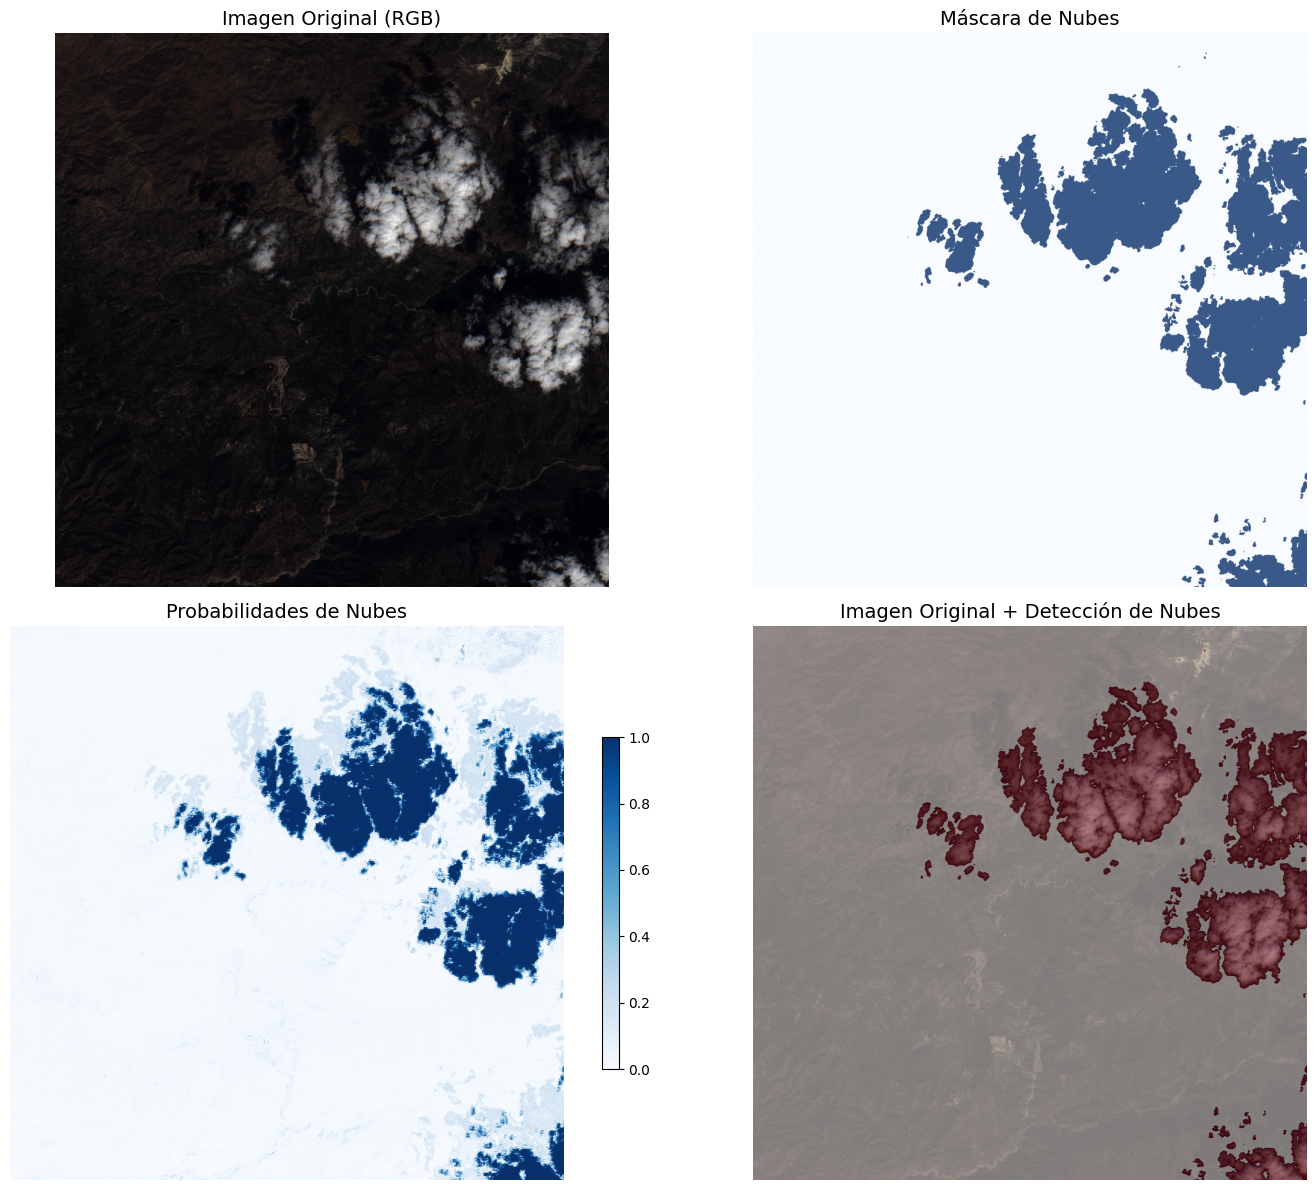

In [14]:
# Visualización de resultados
def create_rgb_image(data, rgb_bands=[3, 2, 1]):
    """
    Crea una imagen RGB a partir de los datos satelitales
    """
    if len(data.shape) == 4:
        data = data[0]  # Remover dimensión temporal
    
    # Seleccionar bandas RGB (ajustar índices si es necesario)
    try:
        rgb = data[:, :, rgb_bands]
        # Normalizar para visualización
        rgb_norm = np.zeros_like(rgb, dtype=np.float32)
        for i in range(3):
            band = rgb[:, :, i]
            rgb_norm[:, :, i] = (band - band.min()) / (band.max() - band.min())
        return np.clip(rgb_norm, 0, 1)
    except:
        # Si no hay suficientes bandas, usar las primeras 3
        if data.shape[2] >= 3:
            rgb = data[:, :, :3]
        else:
            # Crear imagen en escala de grises
            rgb = np.stack([data[:, :, 0]] * 3, axis=2)
        
        rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())
        return np.clip(rgb_norm, 0, 1)

def plot_results(original_data, cloud_mask, cloud_probs):
    """
    Crea visualizaciones de los resultados de detección de nubes
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Imagen original (RGB)
    rgb_image = create_rgb_image(original_data)
    axes[0, 0].imshow(rgb_image)
    axes[0, 0].set_title('Imagen Original (RGB)', fontsize=14)
    axes[0, 0].axis('off')
    
    # Máscara de nubes
    axes[0, 1].imshow(cloud_mask, cmap='Blues', alpha=0.8)
    axes[0, 1].set_title('Máscara de Nubes', fontsize=14)
    axes[0, 1].axis('off')
    
    # Probabilidades de nubes
    im2 = axes[1, 0].imshow(cloud_probs, cmap='Blues', vmin=0, vmax=1)
    axes[1, 0].set_title('Probabilidades de Nubes', fontsize=14)
    axes[1, 0].axis('off')
    plt.colorbar(im2, ax=axes[1, 0], shrink=0.6)
    
    # Superposición: imagen original + máscara de nubes
    axes[1, 1].imshow(rgb_image)
    axes[1, 1].imshow(cloud_mask, cmap='Reds', alpha=0.5)
    axes[1, 1].set_title('Imagen Original + Detección de Nubes', fontsize=14)
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Crear visualizaciones si tenemos resultados
if 'cloud_mask_2d' in locals() and 'cloud_probs_2d' in locals():
    print("Creando visualizaciones...")
    plot_results(processed_data, cloud_mask_2d, cloud_probs_2d)
else:
    print("No hay resultados para visualizar")

\nGuardando resultados...
Máscara de nubes guardada en: cloud_detection_results/cloudy_cloud_mask.npy
Probabilidades guardadas en: cloud_detection_results/cloudy_cloud_probabilities.npy


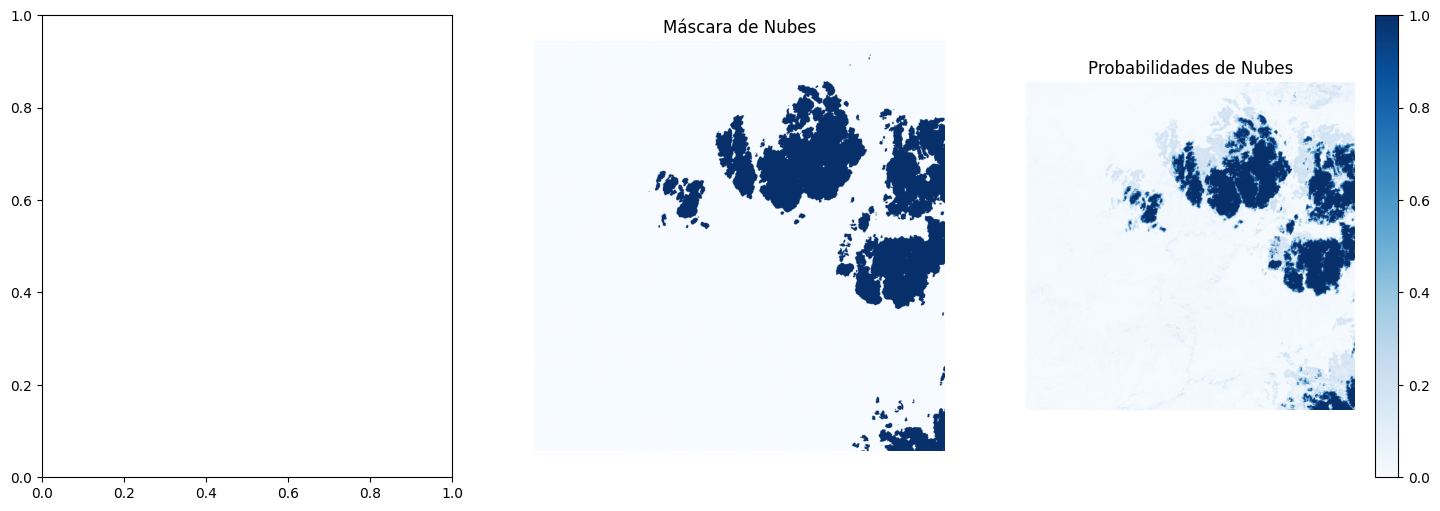

Visualización guardada en: cloud_detection_results/cloudy_cloud_detection_results.png
\n¡Detección de nubes completada exitosamente!
\nArchivos generados:
- Máscara binaria: cloud_detection_results/cloudy_cloud_mask.npy
- Probabilidades: cloud_detection_results/cloudy_cloud_probabilities.npy
- Visualización: cloud_detection_results/cloudy_cloud_detection_results.png


In [15]:
# Guardar resultados
def save_results(cloud_mask, cloud_probs, output_dir="cloud_detection_results"):
    """
    Guarda los resultados de la detección de nubes
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Obtener nombre base del archivo original
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    
    # Guardar máscara de nubes
    mask_path = os.path.join(output_dir, f"{base_name}_cloud_mask.npy")
    np.save(mask_path, cloud_mask)
    print(f"Máscara de nubes guardada en: {mask_path}")
    
    # Guardar probabilidades
    probs_path = os.path.join(output_dir, f"{base_name}_cloud_probabilities.npy")
    np.save(probs_path, cloud_probs)
    print(f"Probabilidades guardadas en: {probs_path}")
    
    # Crear y guardar imagen de visualización
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Imagen RGB original
    if 'processed_data' in locals():
        rgb_image = create_rgb_image(processed_data)
        axes[0].imshow(rgb_image)
        axes[0].set_title('Imagen Original')
        axes[0].axis('off')
    
    # Máscara de nubes
    axes[1].imshow(cloud_mask, cmap='Blues')
    axes[1].set_title('Máscara de Nubes')
    axes[1].axis('off')
    
    # Probabilidades
    im = axes[2].imshow(cloud_probs, cmap='Blues', vmin=0, vmax=1)
    axes[2].set_title('Probabilidades de Nubes')
    axes[2].axis('off')
    plt.colorbar(im, ax=axes[2])
    
    # Guardar figura
    fig_path = os.path.join(output_dir, f"{base_name}_cloud_detection_results.png")
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Visualización guardada en: {fig_path}")
    
    return mask_path, probs_path, fig_path

# Guardar resultados si están disponibles
if 'cloud_mask_2d' in locals() and 'cloud_probs_2d' in locals():
    print("\\nGuardando resultados...")
    try:
        mask_file, probs_file, fig_file = save_results(cloud_mask_2d, cloud_probs_2d)
        print("\\n¡Detección de nubes completada exitosamente!")
        print("\\nArchivos generados:")
        print(f"- Máscara binaria: {mask_file}")
        print(f"- Probabilidades: {probs_file}") 
        print(f"- Visualización: {fig_file}")
    except Exception as e:
        print(f"Error al guardar resultados: {e}")
else:
    print("No hay resultados para guardar")

Probando diferentes umbrales de detección...


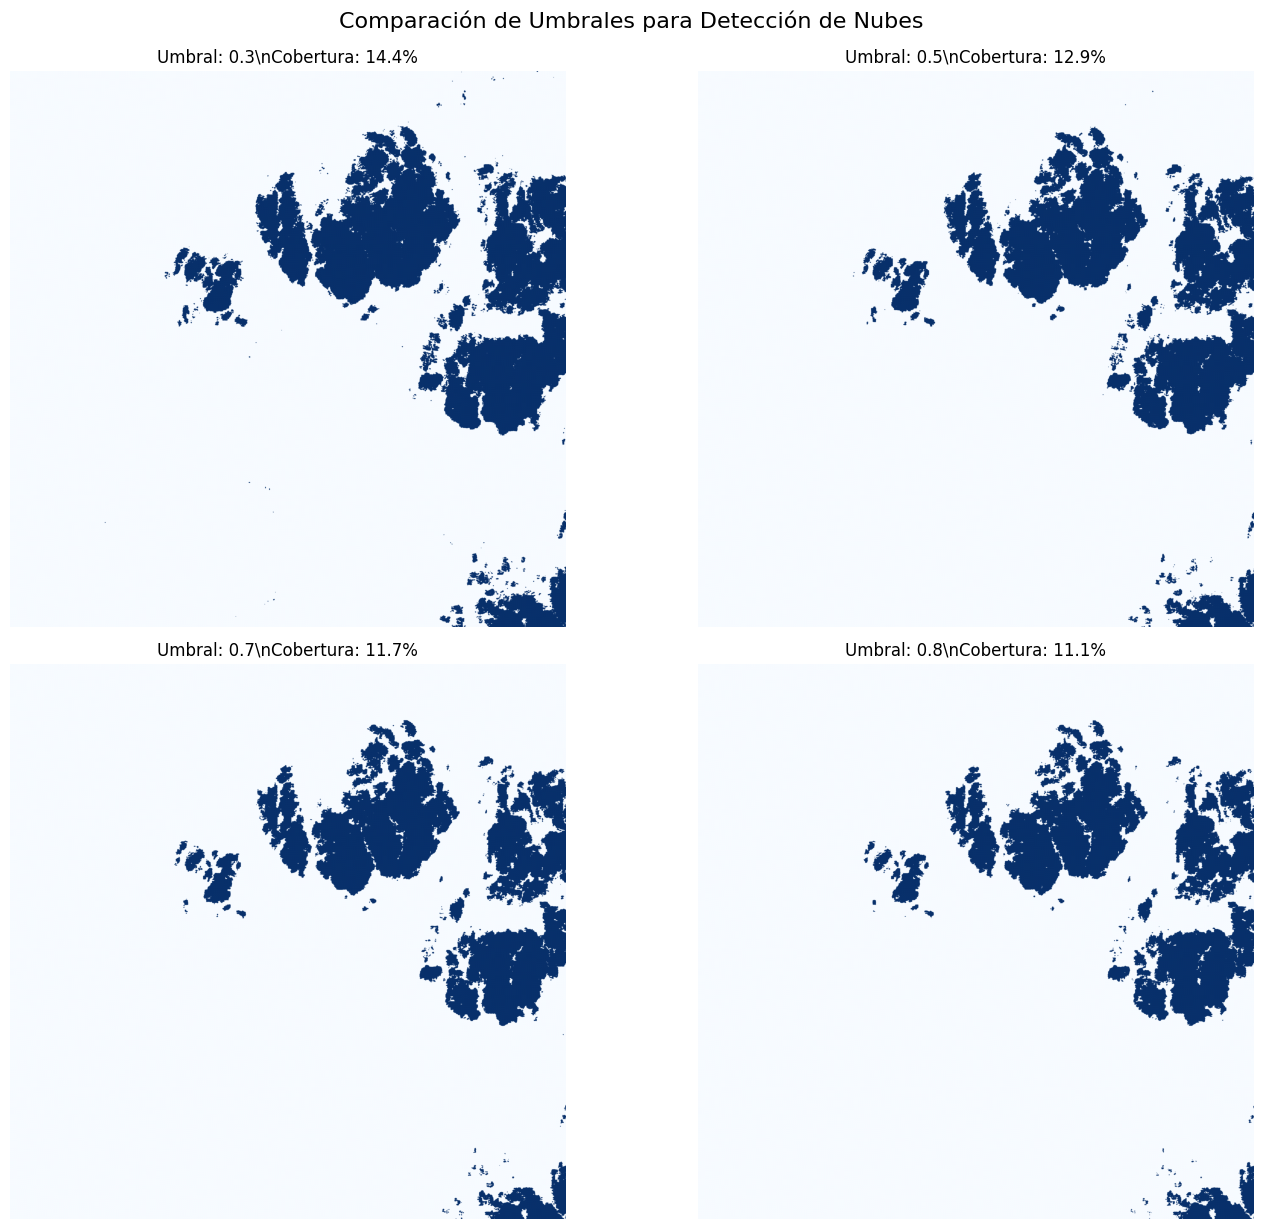

In [16]:
# Experimentar con diferentes parámetros para una detección más refinada
def test_different_thresholds():
    """
    Prueba diferentes umbrales para obtener una detección más precisa
    """
    thresholds = [0.3, 0.5, 0.7, 0.8]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for i, threshold in enumerate(thresholds):
        # Crear detector con umbral específico
        cloud_detector = S2PixelCloudDetector(
            threshold=threshold,
            average_over=2,
            dilation_size=1,
            all_bands=True
        )
        
        # Detectar nubes
        cloud_mask_test = cloud_detector.get_cloud_masks(processed_data)
        cloud_mask_2d_test = cloud_mask_test[0]
        
        # Calcular estadísticas
        cloud_percentage = (np.sum(cloud_mask_2d_test) / cloud_mask_2d_test.size) * 100
        
        # Visualizar
        axes[i].imshow(cloud_mask_2d_test, cmap='Blues')
        axes[i].set_title(f'Umbral: {threshold}\\nCobertura: {cloud_percentage:.1f}%')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Comparación de Umbrales para Detección de Nubes', fontsize=16, y=1.02)
    plt.show()

print("Probando diferentes umbrales de detección...")
test_different_thresholds()

🎨 Creando visualización comparativa mejorada...


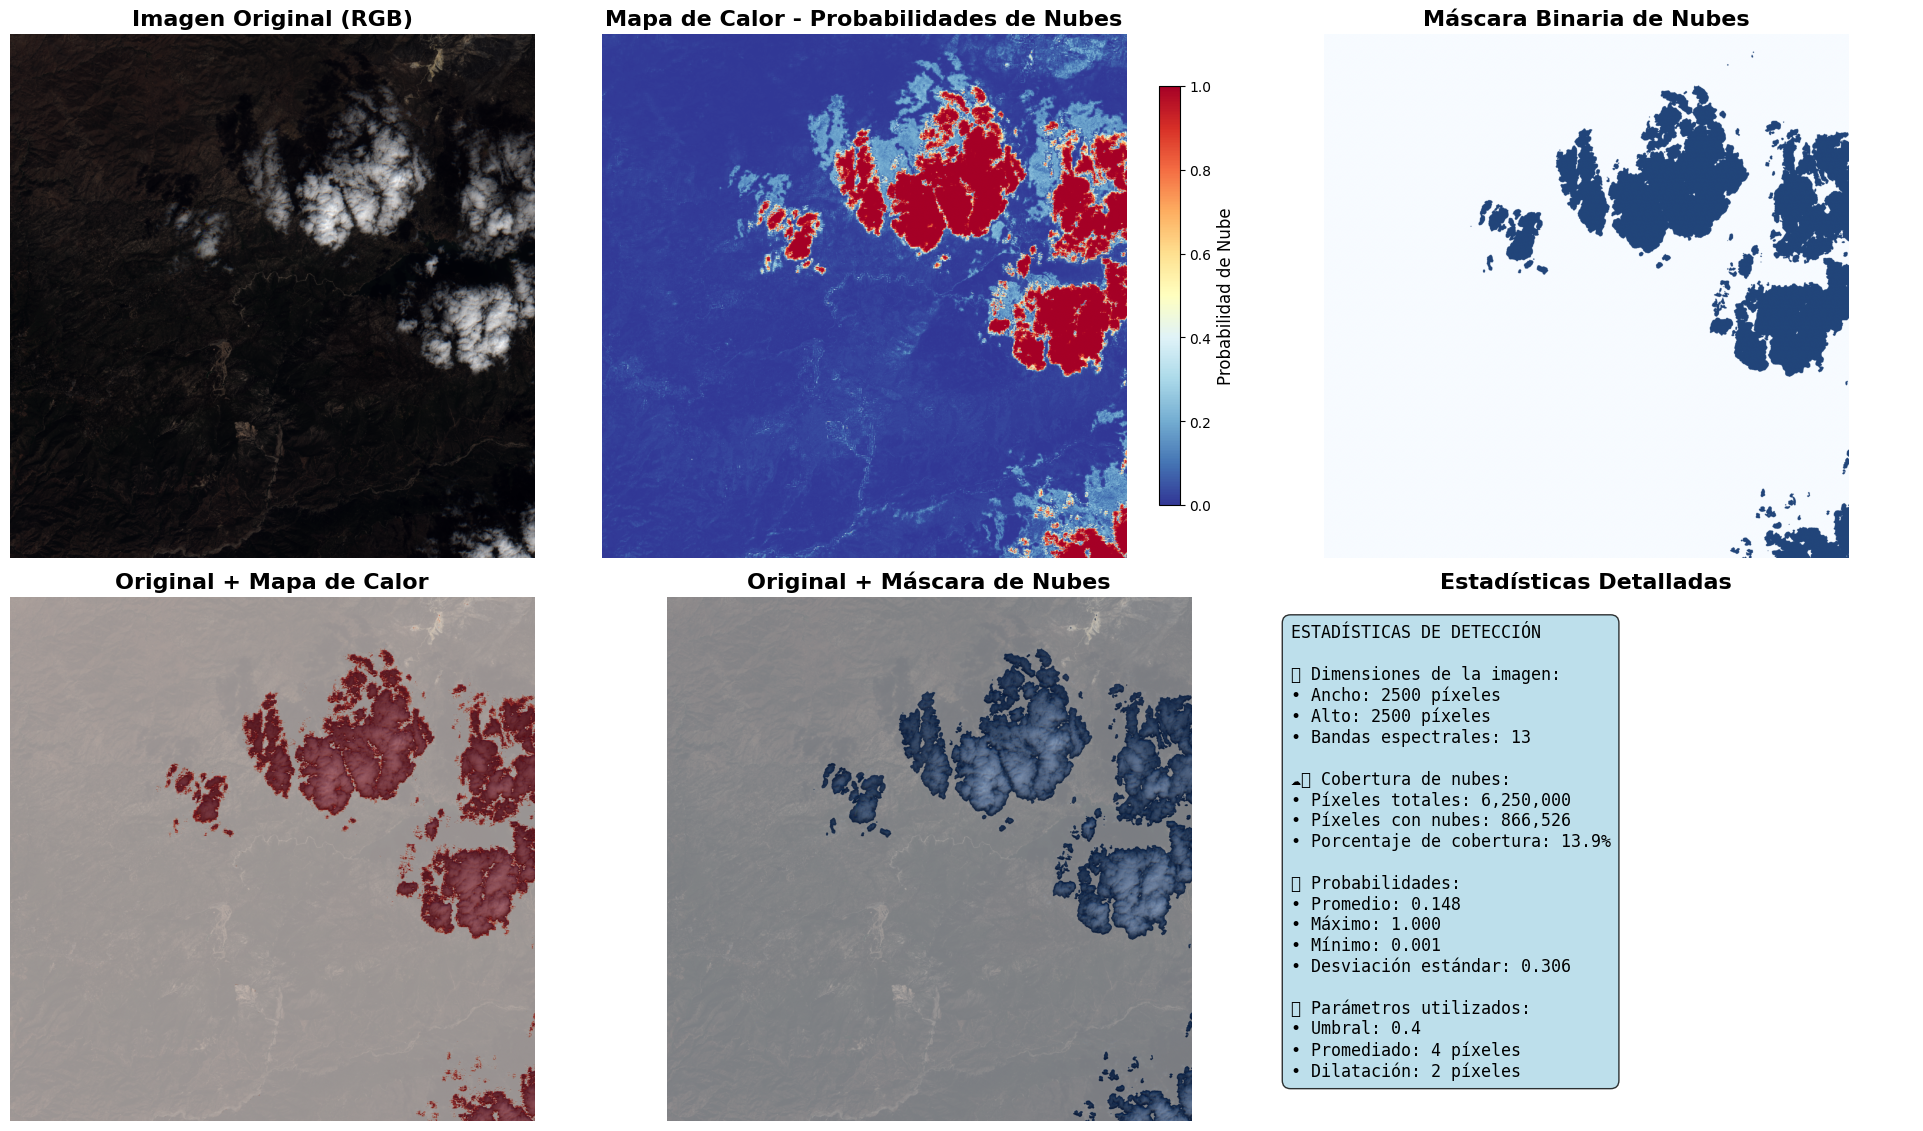


🌈 Creando mapas de calor con diferentes escalas...


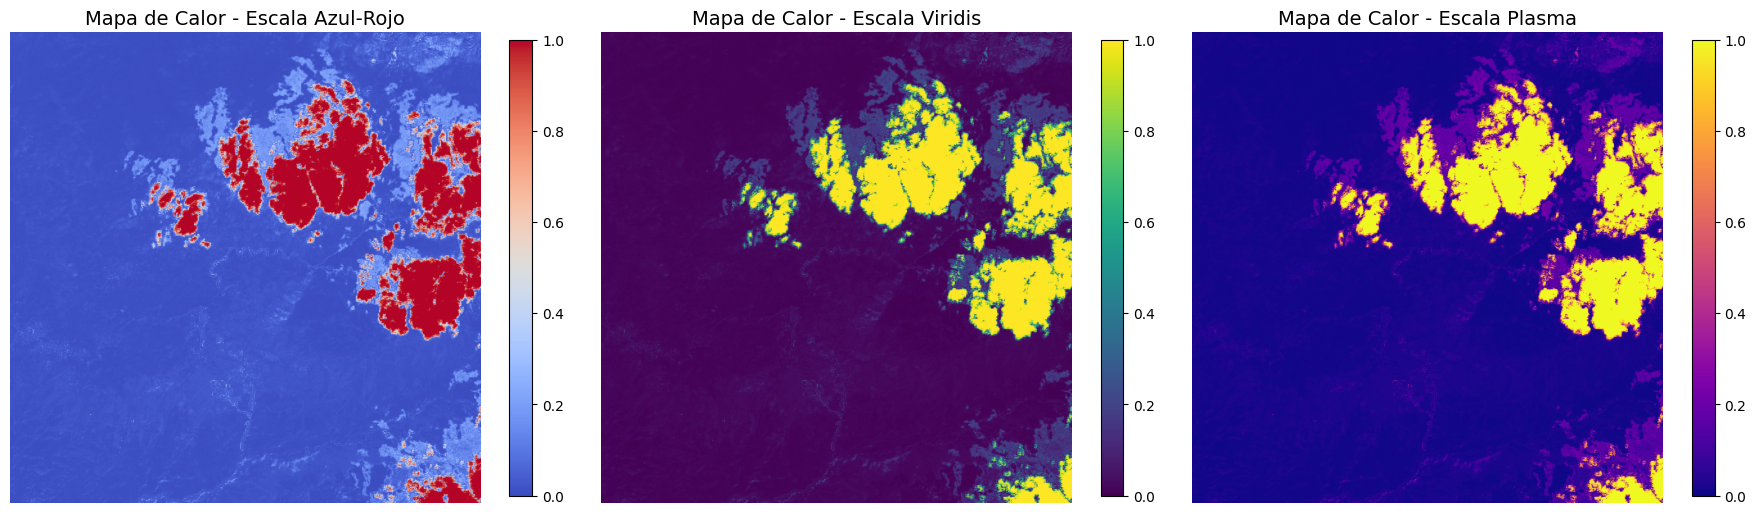

In [17]:
# Visualización mejorada: Comparación lado a lado de máscara, mapa de calor e imagen original
def create_comparison_plot():
    """
    Crea una visualización comparativa clara entre imagen original, mapa de calor y máscara de nubes
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # Crear imagen RGB para visualización
    rgb_image = create_rgb_image(processed_data)
    
    # Fila superior: Visualizaciones individuales
    # 1. Imagen original (RGB)
    axes[0, 0].imshow(rgb_image)
    axes[0, 0].set_title('Imagen Original (RGB)', fontsize=16, fontweight='bold')
    axes[0, 0].axis('off')
    
    # 2. Mapa de calor de probabilidades
    im1 = axes[0, 1].imshow(cloud_probs_2d, cmap='RdYlBu_r', vmin=0, vmax=1)
    axes[0, 1].set_title('Mapa de Calor - Probabilidades de Nubes', fontsize=16, fontweight='bold')
    axes[0, 1].axis('off')
    cbar1 = plt.colorbar(im1, ax=axes[0, 1], shrink=0.8)
    cbar1.set_label('Probabilidad de Nube', fontsize=12)
    
    # 3. Máscara binaria de nubes
    im2 = axes[0, 2].imshow(cloud_mask_2d, cmap='Blues', alpha=0.9)
    axes[0, 2].set_title('Máscara Binaria de Nubes', fontsize=16, fontweight='bold')
    axes[0, 2].axis('off')
    
    # Fila inferior: Superposiciones
    # 4. Original + Mapa de calor superpuesto
    axes[1, 0].imshow(rgb_image)
    im3 = axes[1, 0].imshow(cloud_probs_2d, cmap='Reds', alpha=0.6, vmin=0.3, vmax=1)
    axes[1, 0].set_title('Original + Mapa de Calor', fontsize=16, fontweight='bold')
    axes[1, 0].axis('off')
    
    # 5. Original + Máscara superpuesta
    axes[1, 1].imshow(rgb_image)
    axes[1, 1].imshow(cloud_mask_2d, cmap='Blues', alpha=0.5)
    axes[1, 1].set_title('Original + Máscara de Nubes', fontsize=16, fontweight='bold')
    axes[1, 1].axis('off')
    
    # 6. Estadísticas textuales
    axes[1, 2].axis('off')
    stats_text = f"""ESTADÍSTICAS DE DETECCIÓN
    
📊 Dimensiones de la imagen:
• Ancho: {width} píxeles
• Alto: {height} píxeles
• Bandas espectrales: {bands}

☁️ Cobertura de nubes:
• Píxeles totales: {total_pixels:,}
• Píxeles con nubes: {cloud_pixels:,}
• Porcentaje de cobertura: {cloud_percentage:.1f}%

🎯 Probabilidades:
• Promedio: {np.mean(cloud_probs_2d):.3f}
• Máximo: {np.max(cloud_probs_2d):.3f}
• Mínimo: {np.min(cloud_probs_2d):.3f}
• Desviación estándar: {np.std(cloud_probs_2d):.3f}

🔧 Parámetros utilizados:
• Umbral: 0.4
• Promediado: 4 píxeles
• Dilatación: 2 píxeles"""
    
    axes[1, 2].text(0.05, 0.95, stats_text, transform=axes[1, 2].transAxes, 
                   fontsize=12, verticalalignment='top', fontfamily='monospace',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='lightblue', alpha=0.8))
    axes[1, 2].set_title('Estadísticas Detalladas', fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def create_detailed_heatmap():
    """
    Crea un mapa de calor detallado con diferentes escalas de color
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Mapa de calor estilo 1: Escala azul-rojo
    im1 = axes[0].imshow(cloud_probs_2d, cmap='coolwarm', vmin=0, vmax=1)
    axes[0].set_title('Mapa de Calor - Escala Azul-Rojo', fontsize=14)
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], shrink=0.8)
    
    # Mapa de calor estilo 2: Escala viridis
    im2 = axes[1].imshow(cloud_probs_2d, cmap='viridis', vmin=0, vmax=1)
    axes[1].set_title('Mapa de Calor - Escala Viridis', fontsize=14)
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], shrink=0.8)
    
    # Mapa de calor estilo 3: Escala personalizada
    im3 = axes[2].imshow(cloud_probs_2d, cmap='plasma', vmin=0, vmax=1)
    axes[2].set_title('Mapa de Calor - Escala Plasma', fontsize=14)
    axes[2].axis('off')
    plt.colorbar(im3, ax=axes[2], shrink=0.8)
    
    plt.tight_layout()
    plt.show()

# Ejecutar las visualizaciones mejoradas
if 'cloud_mask_2d' in locals() and 'cloud_probs_2d' in locals():
    print("🎨 Creando visualización comparativa mejorada...")
    create_comparison_plot()
    
    print("\n🌈 Creando mapas de calor con diferentes escalas...")
    create_detailed_heatmap()
else:
    print("❌ Error: No hay datos disponibles para la visualización")